# Model creation stage III (4x8)

In [2]:
%load_ext autoreload
%autoreload 2

# Setup

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tools import common_functions as cf
from tools import regression as reg
from tools import plotting_functions as pf

from tools import sensor_gui as sg

# Folder prefix with all the taxel data
TAXEL_DATA_FOLDER = f"table_calibration/taxel"


# Parameters
SENSOR_LAG = 0 # ms
ARRAY_SIZE = 32

# Automated
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]

In [3]:
taxels_data = []

for i in range(1):
  
  # Load the data
  taxel_data = cf.prepare_data_for_fitting(f"{TAXEL_DATA_FOLDER}{i}", ARRAY_SIZE, SENSOR_LAG, rotation=90 + 1.82, faulty=False, cut_in_half=False)
  taxels_data.append(taxel_data)

Preparing data for fitting: table_calibration/taxel0
True False


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:313: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


In [4]:
# Load models from stage II
import os
import dill

save_path = os.path.join(os.getcwd(), '..', 'models', "4x8")
stage_II_model = dill.load(open(os.path.join(save_path, "stageII"), 'rb'))

In [5]:
stage_II_model.predict(taxels_data[0])

(array([[ 0.03263307, -0.00272795,  0.08662043, ..., -0.06043831,
         -0.1027828 ,  0.00291044],
        [ 0.03046079, -0.00859338,  0.10354337, ..., -0.06368512,
         -0.10717008,  0.00569986],
        [ 0.03764478, -0.00720088,  0.1083883 , ..., -0.06667352,
         -0.1138624 ,  0.01806034],
        ...,
        [-0.01893293, -0.17384941,  0.06746574, ..., -0.02550457,
         -0.11079784,  0.07387145],
        [-0.01930558, -0.17409032,  0.06808267, ..., -0.02513021,
         -0.10972031,  0.06663102],
        [-0.01967829, -0.17433124,  0.06869953, ..., -0.02475602,
         -0.10864297,  0.05939442]]),
 array([[ 0.01613672, -0.01376213,  0.06400969, ..., -0.08436709,
         -0.12398327, -0.03322485],
        [ 0.01453589, -0.01593647,  0.07019562, ..., -0.08412576,
         -0.12243877, -0.02463031],
        [ 0.02292234, -0.01665493,  0.08088489, ..., -0.08473859,
         -0.12937191, -0.00673141],
        ...,
        [-0.01877685, -0.17147044,  0.06294728, ..., -

# STAGE III

Hysteresis

In [6]:
G_z_500mHz, F_comp = stage_II_model.predict(taxels_data[0])
print(G_z_500mHz.shape)

(148274, 96)


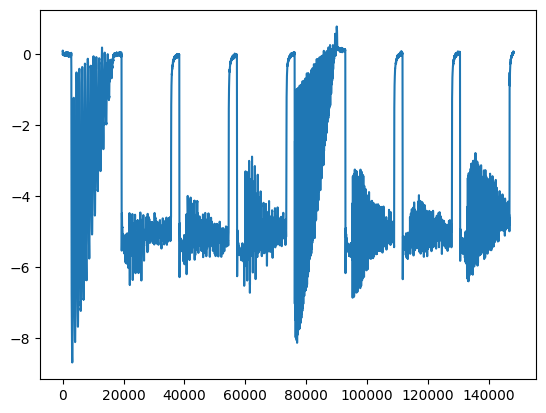

In [7]:
plt.plot(G_z_500mHz[:, 2])

/tmp/ipykernel_78809/2291990033.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(G_z_500mHz[:18000, 2], taxels_data[0]['F_z'][:18000])


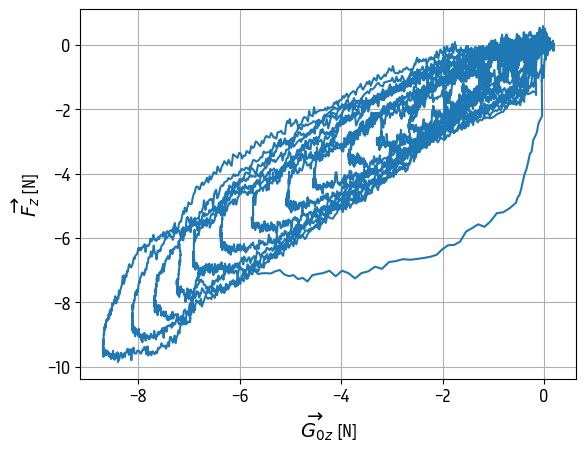

In [8]:
plt.rcParams["font.family"] = "UGent Panno Text"
plt.rcParams["font.size"] = 14

plt.xlabel("$\overrightarrow{G_0}_z$ [N]")
plt.ylabel("$\overrightarrow{F_z}$ [N]")

plt.grid()
# plt.gca().set_aspect('equal')

plt.plot(G_z_500mHz[:18000, 2], taxels_data[0]['F_z'][:18000])

/tmp/ipykernel_78809/590333430.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(taxels_data[0]['F_z'][:18000])


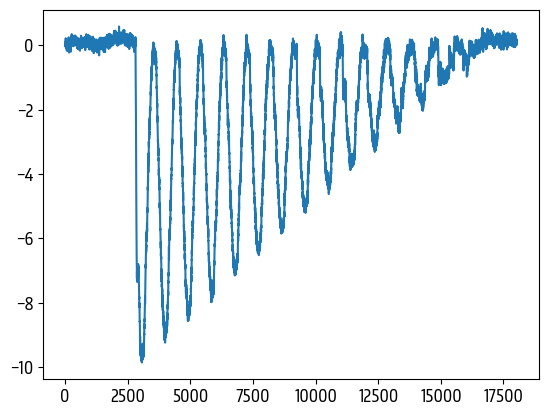

In [9]:
plt.plot(taxels_data[0]['F_z'][:18000])

In [10]:
TFdata = cf.read_csv_file(f"../data/raw/TF/table_calibration/taxel0.csv") 
dt = TFdata['t_wall'][len(TFdata) - 1] - TFdata['t_wall'][0]

SAMPLE_RATE = len(TFdata) / dt

print(SAMPLE_RATE)

397.2544115678425


138793


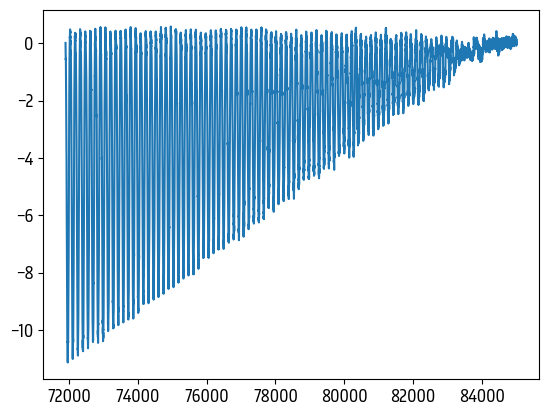

In [15]:
print(len(TFdata))
min_index = int(2500 + len(TFdata)/2)
max_index = int(SAMPLE_RATE*33+2500 + len(TFdata)/2)

plt.plot(TFdata['F_z'][min_index:max_index])


In [16]:
def delay_signal(signal, N):
    """
    Delays the input signal by N samples.

    Parameters:
    signal (np.ndarray): The input signal array.
    N (int): The number of samples to delay. Positive values delay the signal,
             negative values advance the signal.

    Returns:
    np.ndarray: The delayed signal.
    """
    if not isinstance(signal, np.ndarray):
        raise TypeError("Input signal must be a numpy array")
    
    if not isinstance(N, int):
        raise TypeError("Delay value N must be an integer")

    # Handle positive delay
    if N > 0:
        delayed_signal = np.concatenate((np.zeros(N), signal))
        # Truncate the signal to maintain the original length
        delayed_signal = delayed_signal[:len(signal)]
    # Handle negative delay (advance)
    elif N < 0:
        delayed_signal = signal[-N:]  # Take the samples from -N to the end
        # Append zeros to the beginning to maintain the original length
        delayed_signal = np.concatenate((delayed_signal, np.zeros(-N)))
    else:
        # No delay
        delayed_signal = signal

    return delayed_signal

import numpy as np
from scipy.signal import firwin, lfilter

def lowpass_filter(signal, cutoff_freq, sample_rate, numtaps=101):
    """
    Apply a lowpass filter to the input signal.

    Parameters:
    signal (np.ndarray): The input signal array.
    cutoff_freq (float): The cutoff frequency of the filter in Hz.
    sample_rate (float): The sampling rate of the signal in Hz.
    numtaps (int): The number of taps (coefficients) in the filter.

    Returns:
    np.ndarray: The filtered signal.
    """
    if not isinstance(signal, np.ndarray):
        raise TypeError("Input signal must be a numpy array")
    
    if not isinstance(cutoff_freq, (float, int)):
        raise TypeError("Cutoff frequency must be a float or an integer")

    if not isinstance(sample_rate, (float, int)):
        raise TypeError("Sample rate must be a float or an integer")

    if not isinstance(numtaps, int):
        raise TypeError("Number of taps must be an integer")

    # Normalize the cutoff frequency with respect to the Nyquist frequency
    nyquist_rate = sample_rate / 2.0
    normalized_cutoff = cutoff_freq / nyquist_rate

    # Design the FIR filter using the window method
    taps = firwin(numtaps, normalized_cutoff, window='hamming')

    # Apply the filter to the signal using lfilter
    filtered_signal = lfilter(taps, 1.0, signal)

    return filtered_signal

/tmp/ipykernel_78809/3194263543.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X = taxels_data[0]['Z0'][min_index:max_index]
/tmp/ipykernel_78809/3194263543.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Y = taxels_data[0]['F_z'][min_index:max_index]


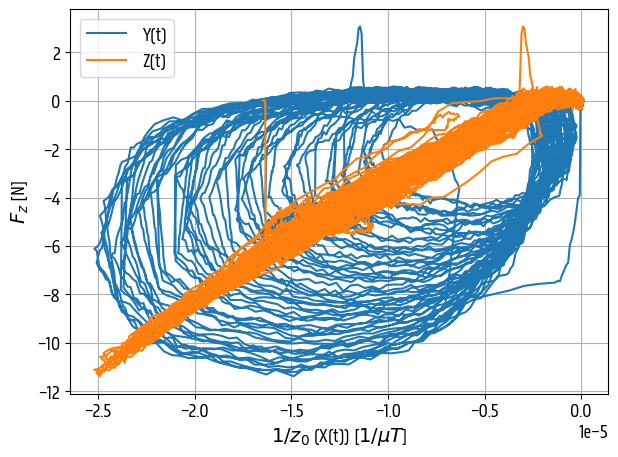

In [29]:
# plt.xlabel("$\overrightarrow{G_0}_z$ [N]")
# plt.ylabel("$\overrightarrow{F_z}$ [N]")

plt.grid()

X = taxels_data[0]['Z0'][min_index:max_index]
Y = taxels_data[0]['F_z'][min_index:max_index]
Z = delay_signal(Y.to_numpy(), 32)

plt.plot(X, Y, label='Y(t)')
plt.plot(X, Z, label='Z(t)')

plt.legend()

pr

plt.xlabel(f'$1/z_0$ (X(t)) [$1/ \mu T$]')
plt.ylabel(f'$F_z$ [N]')

plt.tight_layout()
plt.savefig("plots/c3_hyst_latency.pdf", format="pdf", bbox_inches="tight")

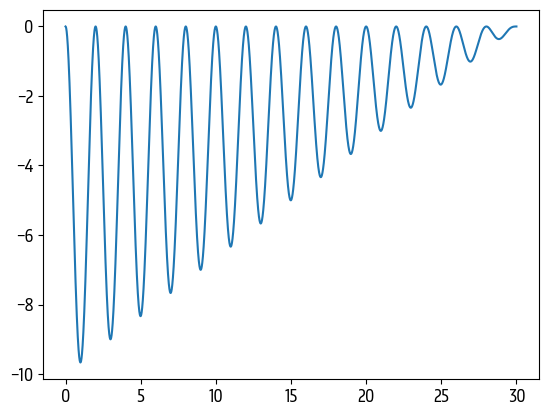

In [18]:
# Now try to simulate the force
def descending_sine_wave(time, frequency, max_amplitude, phase_shift = 0, shifted=True):
    max_time = np.max(time)
    time_adjusted = time - max_time
    if shifted:
        y_values = max_amplitude / max_time / 2 * time * (np.sin(2 * np.pi * frequency * time_adjusted - np.pi/2 + phase_shift) + 1)
    else:
        y_values = max_amplitude / max_time * time * np.sin(2 * np.pi * frequency * time_adjusted - np.pi/2 + phase_shift)
        
    return y_values[::-1]



def generate_forces(frequency, max_force, length, sample_rate=400):
  force_rate = abs(max_force) / length

  time = np.linspace(0, abs(max_force) / force_rate, int(abs(max_force) / force_rate * sample_rate))  # Time values from 0 to 2 seconds

  normal_force_values = descending_sine_wave(time, frequency, max_force, 0, True)
  
  return normal_force_values


normal_force_values = generate_forces(0.5, -10, 30) 
time = np.linspace(0, 30, len(normal_force_values))
plt.plot(time, normal_force_values)

Delay: 0.0625 s


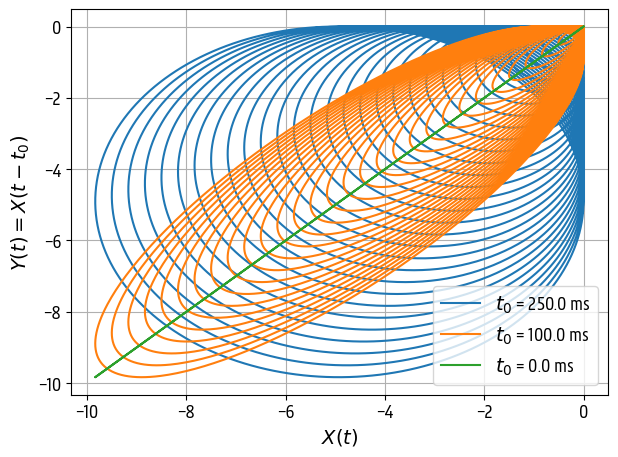

In [42]:
from scipy.signal import butter, lfilter, freqz, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

delay = 25 
print(F"Delay: {delay/400} s")


# G_sim = taxels_data[0]['F_z'][min_index:max_index].to_numpy()
normal_force_values = generate_forces(1, -10, 30) 
G_sim = normal_force_values

# G_sim = butter_lowpass_filter(G_sim, 4, 400)

for delay in [0, 40, 100][::-1]:
    G_sim_delayed = delay_signal(G_sim, delay)
    plt.plot(normal_force_values, G_sim_delayed, label=f"$t_0$ = {delay/0.4} ms")
    

plt.xlabel("$X(t)$")
plt.ylabel("$Y(t)=X(t-t_0)$")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("plots/c3_hyst_ex2.pdf", format="pdf", bbox_inches="tight")
plt.show()

# plt.plot(G_sim, taxels_data[0]['F_z'][min_index:max_index].to_numpy())
# plt.plot(G_z_500mHz[min_index:max_index, 2], taxels_data[0]['F_z'][min_index:max_index])


/tmp/ipykernel_116707/4127333769.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(G_z_500mHz[60000:, 1], taxels_data[0]['F_y'][60000:])


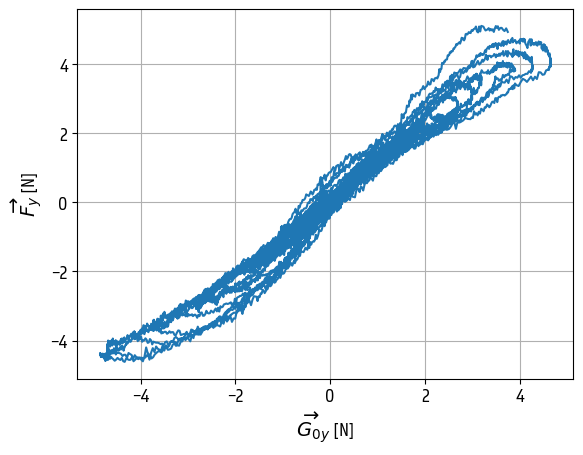

In [64]:
plt.rcParams["font.family"] = "UGent Panno Text"
plt.rcParams["font.size"] = 14

plt.xlabel("$\overrightarrow{G_0}_y$ [N]")
plt.ylabel("$\overrightarrow{F_y}$ [N]")

plt.grid()
# plt.gca().set_aspect('equal')

plt.plot(G_z_500mHz[60000:, 1], taxels_data[0]['F_y'][60000:])

/tmp/ipykernel_116707/2657121871.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(taxels_data[0]['Z'][:18000], taxels_data[0]['F_z'][:18000])


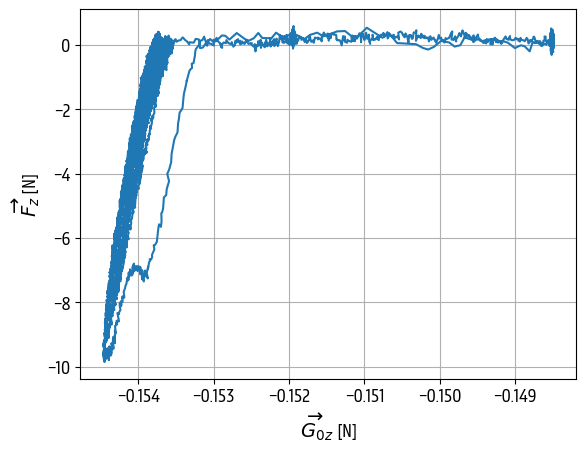

In [73]:
plt.rcParams["font.family"] = "UGent Panno Text"
plt.rcParams["font.size"] = 14

plt.xlabel("$\overrightarrow{G_0}_z$ [N]")
plt.ylabel("$\overrightarrow{F_z}$ [N]")

plt.grid()
# plt.gca().set_aspect('equal')

plt.plot(taxels_data[0]['Z'][:18000], taxels_data[0]['F_z'][:18000])